In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import os 
import pickle 
import time
from utils.utils import *

%matplotlib inline

## Load data paths

In [2]:
cars, notcars = pickle.load( open( "data_path.p", "rb" ) )

## Extract features for training and test

In [3]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [4]:
sample_size = 500

# Get training data
car_samples = cars['train']
notcar_samples = notcars['train']
car_features = extract_features(car_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X_train = np.vstack((car_features, notcar_features)).astype(np.float64)     
# Define the labels vector
y_train = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Get testing data
car_samples = cars['test']
notcar_samples = notcars['test']
car_features = extract_features(car_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X_test = np.vstack((car_features, notcar_features)).astype(np.float64)     
# Define the labels vector
y_test = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Fit a per-column scaler

In [5]:
temporal = np.concatenate([X_train, X_test])
X_scaler = StandardScaler().fit(temporal)
scaled_data = X_scaler.transform(temporal)
X_train=scaled_data[:y_train.shape[0]]
X_test=scaled_data[y_train.shape[0]:]

## Train a classifier

In [6]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5340
7.11 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9868


## Using PCA for dimensionality reduction

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
X_train_reduced = pca.fit_transform(X_train)

np.sum(pca.explained_variance_ratio_)

0.86755341159628463

In [8]:
print('Previous dimensionality of data = ', X_train.shape)
print('New dimensionality of data = ', X_train_reduced.shape)

Previous dimensionality of data =  (14211, 5340)
New dimensionality of data =  (14211, 1000)


In [9]:
# Use a linear SVC 
svc2 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc2.fit(X_train_reduced, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc2.score(X_train_reduced, y_train), 4))
print('Test Accuracy of SVC = ', round(svc2.score(pca.transform(X_test), y_test), 4))
# Check the prediction time for a single sample
t=time.time()

2.15 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9856


## Tuning the classification model

In [10]:
from sklearn import grid_search
parameters = {'loss':('hinge', 'squared_hinge'), 'C':[0.1, 1, 10]}
svr = LinearSVC()
clf = grid_search.GridSearchCV(svr, parameters)
t=time.time()
clf.fit(X_train_reduced, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Train Accuracy of SVC = ', round(clf.score(X_train_reduced, y_train), 4))
print('Test Accuracy of SVC = ', round(clf.score(pca.transform(X_test), y_test), 4))

/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


16.45 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9856


In [13]:
print("These are the best parameters found using grid search:", clf.best_params_)

These are the best parameters found using grid search: {'loss': 'hinge', 'C': 0.1}


## Saving classifier, scaler and PCA

In [14]:
pickle.dump([clf, X_scaler, pca], open( "trained_classifier.p", "wb"))

## Load pretrained classifier

In [4]:
clf, X_scaler, pca = pickle.load( open( "trained_classifier.p", "rb" ) )

/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Drawing searching windows

In [6]:
def display_image(img):
    return convert_color(img,'BGR2RGB')

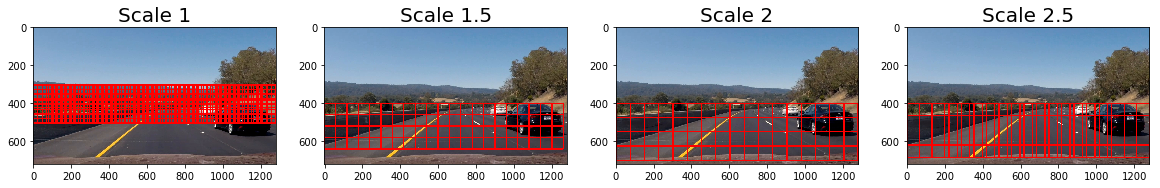

In [87]:
x_start_stop = [50, None]
y_start_stop = [350, None] # Min and max in y to search in slide_window()


image = cv2.imread('./test_images/test10.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[304,504], 
                    xy_window=(80, 80), xy_overlap=(0.7, 0.7))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,640], 
                    xy_window=(120, 120), xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,700], 
                    xy_window=(150, 150), xy_overlap=(0.5, 0.5))
windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,None], 
                    xy_window=(220, 220), xy_overlap=(0.7, 0.7))

window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6) 
window_img2 = draw_boxes(draw_image, windows2, color=(0, 0, 255), thick=6) 
window_img3 = draw_boxes(draw_image, windows3, color=(0, 0, 255), thick=6) 
window_img4 = draw_boxes(draw_image, windows4, color=(0, 0, 255), thick=6) 

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(display_image(window_img))
ax1.set_title('Scale 1', fontsize=20)
ax2.imshow(display_image(window_img2))
ax2.set_title('Scale 1.5', fontsize=20)
ax3.imshow(display_image(window_img3))
ax3.set_title('Scale 2', fontsize=20)
ax4.imshow(display_image(window_img4))
ax4.set_title('Scale 2.5', fontsize=20)

all_windows = windows + windows2 + windows3 + windows4

/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


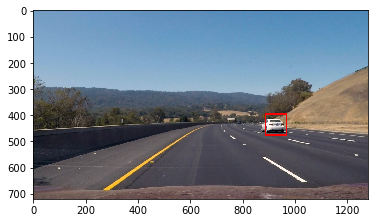

In [27]:
image = cv2.imread('./test_images/test3.jpg')
draw_image = np.copy(image)

hot_windows = search_windows(image, all_windows, clf, X_scaler, pca, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(display_image(window_img))

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)